# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ensemble Learning 

"If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will  
often get better predictions than with the best individual predictor. A group of predictors  
is called an ensemble; thus, this technique is called Ensemble Learning, and an  
Ensemble Learning algorithm is called an Ensemble method."

"As discussed in Chapter 2, you will often use Ensemble methods near the end of a  
project, once you have already built a few good predictors, to combine them into an  
even better predictor."

# Voting Classifier

"A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classifier
is called a hard voting classifier (see Figure 7-2)."

![title](images/voting_classifier_1.png)
![title](images/voting_classifier_2.png)

"Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the  
best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning  
it does only slightly better than random guessing), the ensemble can still be a  
strong learner (achieving high accuracy), provided there are a sufficient number of  
weak learners and they are sufficiently diverse."

TIP:"Ensemble methods work best when the predictors are as independent  
from one another as possible. One way to get diverse classifiers  
is to train them using very different algorithms. This increases the  
chance that they will make very different types of errors, improving  
the ensemble’s accuracy."

In [15]:
heads_proba = 0.51
# Note: np.random.rand(10000, 10) return an array of 10 columns and 10,000 rows where each number is x < 1
# np.random.rand(10000, 10) < heads_proba makes a boolean so the array is an array of 1's and 0's
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
print("Coin Tosses: ")
print(coin_tosses)
# Note: np.cumsum(coin_tosses, axis = 0) performs the cumulative sum over the rows
# Np.arrange(1, 10001) creates an array from 1 - 10,000
# .reshape(-1,1) converts the array to a array of 10,000 rows and 1 column
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
print("Cumulative Sum")
print(np.cumsum(coin_tosses, axis=0))
print("Np Arrange")
print(np.arange(1, 10001).reshape(-1,1))
print("Np Arrange with Reshape")
print(np.arange(1, 10001).reshape(-1, 1))
print("Cumulative Head Ratio")
print(cumulative_heads_ratio)

Coin Tosses: 
[[0 0 0 ... 1 1 0]
 [0 1 1 ... 1 0 1]
 [1 1 1 ... 0 1 1]
 ...
 [1 0 1 ... 1 1 1]
 [0 0 0 ... 0 1 1]
 [1 1 1 ... 1 0 0]]
Cumulative Sum
[[   0    0    0 ...    1    1    0]
 [   0    1    1 ...    2    1    1]
 [   1    2    2 ...    2    2    2]
 ...
 [5036 5092 5134 ... 5148 5090 5074]
 [5036 5092 5134 ... 5148 5091 5075]
 [5037 5093 5135 ... 5149 5091 5075]]
Np Arrange
[[    1]
 [    2]
 [    3]
 ...
 [ 9998]
 [ 9999]
 [10000]]
Cumulative Sum / Np Arrange
[[    1]
 [    2]
 [    3]
 ...
 [ 9998]
 [ 9999]
 [10000]]
Cumulative Head Ratio
[[0.         0.         0.         ... 1.         1.         0.        ]
 [0.         0.5        0.5        ... 1.         0.5        0.5       ]
 [0.33333333 0.66666667 0.66666667 ... 0.66666667 0.66666667 0.66666667]
 ...
 [0.50370074 0.50930186 0.5135027  ... 0.51490298 0.50910182 0.5075015 ]
 [0.50365037 0.50925093 0.51345135 ... 0.51485149 0.50915092 0.50755076]
 [0.5037     0.5093     0.5135     ... 0.5149     0.5091     0.5075    ]

Saving figure law_of_large_numbers_plot


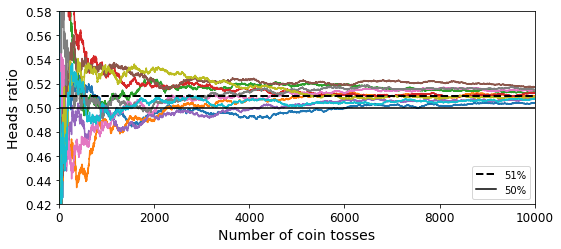

In [16]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [19]:
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [25]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


"There you have it! The voting classifier slightly outperforms all the individual classifiers."

"If all classifiers are able to estimate class probabilities (i.e., they all have a predict_proba() method),  
then you can tell Scikit-Learn to predict the class with the  
highest class probability, averaged over all the individual classifiers. This is called soft  
voting. It often achieves higher performance than hard voting because it gives more  
weight to highly confident votes. All you need to do is replace voting="hard" with  
voting="soft" and ensure that all classifiers can estimate class probabilities. This is  
not the case for the SVC class by default, so you need to set its probability hyperparameter  
to True (this will make the SVC class use cross-validation to estimate class  
probabilities, slowing down training, and it will add a predict_proba() method). If  
you modify the preceding code to use soft voting, you will find that the voting classifier  
achieves over 91.2% accuracy!"

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability = True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting

"One way to get a diverse set of classifiers is to use very different training algorithms,  
as just discussed. Another approach is to use the same training algorithm for every  
predictor and train them on different random subsets of the training set"

"When sampling is performed with replacement, this method is called bagging (short for bootstrap  
aggregating). When sampling is performed without replacement, it is called pasting"

"In other words, both bagging and pasting allow training instances to be sampled several  
times across multiple predictors, but only bagging allows training instances to be  
sampled several times for the same predictor. This sampling and training process is  
represented in Figure 7-4."

![title](images/bagging_and_pasting_1.png)

"Once all predictors are trained, the ensemble can make a prediction for a new  
instance by simply aggregating the predictions of all predictors. The aggregation  
function is typically the statistical mode (i.e., the most frequent prediction, just like a  
hard voting classifier) for classification, or the average for regression. Each individual  
predictor has a higher bias than if it were trained on the original training set, but  
aggregation reduces both bias and variance.4 Generally, the net result is that the  
ensemble has a similar bias but a lower variance than a single predictor trained on the  
original training set."

## Bagging and Pasting in Scikit-Learn

"Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier class (or BaggingRegressor for regression)."

In [36]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score
print("Bagging Accuracy: ", accuracy_score(y_test, y_pred))

Bagging Accuracy:  0.904


To performing pasting, set bootstrap = False

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

past_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=False, random_state=42)
past_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [35]:
from sklearn.metrics import accuracy_score
print("Pasting Accuracy: ", accuracy_score(y_test, y_pred))

Pasting Accuracy:  0.92


In [31]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Decision Tree Accuracy: ", accuracy_score(y_test, y_pred_tree))

Decision Tree Accuracy:  0.856


NOTE "The BaggingClassifier automatically performs soft voting  
instead of hard voting if the base classifier can estimate class probabilities  
(i.e., if it has a predict_proba() method), which is the case  
with Decision Tree classifiers."

In [39]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


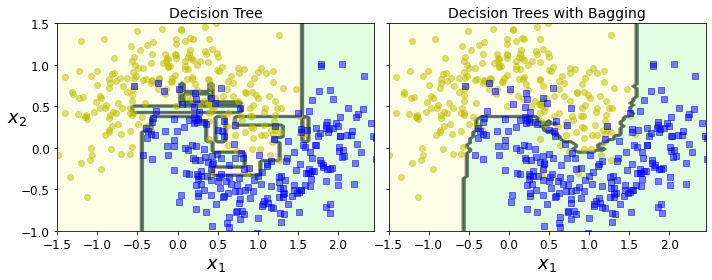

In [45]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

"As you can see, the ensemble’s predictions will likely  
generalize much better than the single Decision Tree’s predictions: the ensemble has a  
comparable bias but a smaller variance (it makes roughly the same number of errors  
on the training set, but the decision boundary is less irregular)."

"Bootstrapping introduces a bit more diversity in the subsets that each predictor is  
trained on, so bagging ends up with a slightly higher bias than pasting; but the extra  
diversity also means that the predictors end up being less correlated, so the ensemble’s  
variance is reduced. Overall, bagging often results in better models, which explains  
why it is generally preferred. However, if you have spare time and CPU power, you  
can use cross-validation to evaluate both bagging and pasting and select the one that  
works best."

## Out-of-Bag Evaluation

"With bagging, some instances may be sampled several times for any given predictor,  
while others may not be sampled at all. By default a BaggingClassifier samples m  
training instances with replacement (bootstrap=True), where m is the size of the  
training set. This means that only about 63% of the training instances are sampled on  
average for each predictor.6 The remaining 37% of the training instances that are not  
sampled are called out-of-bag (oob) instances. Note that they are not the same 37%  
for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on  
these instances, without the need for a separate validation set. You can evaluate the  
ensemble itself by averaging out the oob evaluations of each predictor.  

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to  
request an automatic oob evaluation after training. The following code demonstrates  
this. The resulting evaluation score is available through the oob_score_ variable:" 

In [50]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=42)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

"According to this oob evaluation, this BaggingClassifier is likely to achieve about  
89.6% accuracy on the test set. Let’s verify this:"

In [54]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

Close enough!

"The oob decision function for each training instance is also available through the  
oob_decision_function_ variable. In this case (since the base estimator has a pre   
dict_proba() method), the decision function returns the class probabilities for each   
training instance. For example, the oob evaluation estimates that the first training  
instance has a 68.25% probability of belonging to the positive class (and 31.75% of  
belonging to the negative class):"

In [56]:
# bag_clf.oob_decision_function_